# Complaints Evaluated by the Commission on Police Practices

In 2020, voter-approved Measure B created a new independent Commission on Police Practices (CPP) that replaced the Community Review Board on Police Practices (CRB). The CPP independently investigates officer-involved shootings, in-custody deaths, & other significant incidents in a process that is transparent and accountable to the community. The CPP also evaluates SDPD policies, practices, training, and protocols. This dataset includes all cases the CPP reviewed and closed out since the beginning of FY 2019.

The mission of the Commission is to hold law enforcement accountable to the community and to increase community trust in law enforcement, resulting in increased safety for both the community and law enforcement. To learn more, visit sandiego.gov/cpp/about

Each case in this dataset is identified by a unique case id and case number. A single case may involve multiple allegations and multiple officers. In the FY2019 file, each row represents one allegation and finding per officer in the complaint. Each officer named in the complaint is assigned an anonymous person id in the pid field that is unique for that case id. Starting in FY2020, cases and allegation are in separate files that can be joined on the id and case_number fields.

The body worn camera details file included with this dataset lists each officer (pid) per complaint and whether that officer had a body worn camera on or off during the incident under review.


##  Import Libraries

In [32]:
import requests
import pandas as pd
import time
from sqlalchemy import create_engine
import os
from bs4 import BeautifulSoup
import csv
import mysql.connector
import getpass
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

# Data Aquisition

https://data.sandiego.gov/datasets/crb-cases/

In [9]:
# Set the URL for the page with the download links
url = 'https://data.sandiego.gov/datasets/crb-cases/'

# Set the folder path to store the CSV files
folder_path = 'C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/'   # Replace with the desired folder path

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Fetch the HTML content
response = requests.get(url)
if response.status_code == 200:
    html_content = response.text

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all <paper-button> elements with the class "resource-table-button"
    button_elements = soup.find_all('paper-button', class_='resource-table-button')

    # Extract the download links
    download_links = []
    for button in button_elements:
        # Get the "property" attribute value
        property_value = button.get('property')

        # Check if it's the download link button
        if property_value == 'dcat:accessURL':
            # Get the URL from the parent <a> tag
            url = button.parent['href']
            download_links.append(url)

    # Download and save each CSV file
    for link in download_links:
        # Set the filename based on the last part of the URL
        file_name = link.split('/')[-1]

        # Fetch the CSV data
        response = requests.get(link)
        if response.status_code == 200:
            csv_data = response.content

            # Save the CSV file to the folder
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'wb') as file:
                file.write(csv_data)
            print(f"CSV file saved to: {file_path}")
        else:
            print(f"Failed to fetch the CSV file: {link}")
else:
    print("Failed to fetch the HTML content.")


CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_cases_fy2022_datasd.csv
CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_allegations_fy2022_datasd.csv
CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_cases_bwc_fy2022_datasd.csv
CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_cases_fy2021_datasd.csv
CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_allegations_fy2021_datasd.csv
CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_cases_bwc_fy2021_datasd.csv
CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_cases_fy2020_datasd.csv
CSV file saved to: C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/crb_allegations_

In [10]:
# Set the MySQL database connection details
host = 'localhost'  # Replace with your MySQL host
user = 'root'  # Replace with your MySQL username
password = getpass.getpass(prompt='Password:',stream=None)  # Replace with your MySQL password

In [15]:
# Set the folder path containing the CSV files
folder_path = 'C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-599/project_data/'  # Replace with the folder path where CSV files are stored

# Create a MySQL database connection
cnx = mysql.connector.connect(host=host, user=user, password=password)
cursor = cnx.cursor()

# Create the 'crb' database if it doesn't exist
create_database_query = 'CREATE DATABASE IF NOT EXISTS crb'
cursor.execute(create_database_query)

In [16]:
# Use the 'crb' database
use_database_query = 'USE crb'
cursor.execute(use_database_query)

In [13]:
# Fetch the list of CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Iterate over each CSV file and create a table in the 'crb' database
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    table_name = csv_file[:-4]  # Remove the '.csv' extension to use it as the table name

    # Read the CSV file
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)

        # Read the header row to extract the column names
        header_row = next(csv_reader)
        column_names = [col.strip() for col in header_row]  # Remove leading/trailing spaces

        # Initialize a dictionary to store the maximum lengths for each column
        max_lengths = {col: 0 for col in column_names}

        # Iterate over each row to determine the maximum length for each column
        for row in csv_reader:
            for col, value in zip(column_names, row):
                value_length = len(value.strip())  # Get the length of the value without leading/trailing spaces
                max_lengths[col] = max(max_lengths[col], value_length)

        # Generate the CREATE TABLE query with the appropriate column lengths
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ('
        for col in column_names:
            column_length = max_lengths[col] + 10  # Add additional buffer to the maximum length
            create_table_query += f'`{col}` VARCHAR({column_length}), '
        create_table_query = create_table_query.rstrip(', ') + ')'

        # Create the table in the 'crb' database
        cursor.execute(create_table_query)

        # Reset the file pointer to the beginning of the CSV file
        file.seek(0)

        # Skip the header row
        next(csv_reader)

        # Iterate over each row and insert into the table
        for row in csv_reader:
            insert_query = f'INSERT INTO `{table_name}` VALUES ({",".join("%s" for _ in row)})'
            values = [value.strip() for value in row]

            cursor.execute(insert_query, values)

# Commit the changes and close the database connection
cnx.commit()
cursor.close()

True

In [29]:
tables = pd.DataFrame(pd.read_sql('Show Tables', cnx))
tables

,Tables_in_crb
0,crb_allegations_fy2020_datasd
1,crb_allegations_fy2021_datasd
2,crb_allegations_fy2022_datasd
3,crb_cases_bwc_fy19_datasd
4,crb_cases_bwc_fy2020_datasd
5,crb_cases_bwc_fy2021_datasd
6,crb_cases_bwc_fy2022_datasd
7,crb_cases_fy19_datasd
8,crb_cases_fy2020_datasd
9,crb_cases_fy2021_datasd


In [28]:
dict_df = pd.DataFrame(pd.read_sql('SELECT * FROM dictionary', cnx))
dict_df

,﻿field,description,possible_values
0,id,Case id,
1,case_number,Case number,
2,team,CRB Team number,
3,date_assigned,Date assigned to CRB,
4,date_completed,Date CRB team completed case,
5,date_presented,Date CRB deliberated on case,
6,days_number,,
7,days_60_or_less,Number of days for case to be reviewed,
8,days_90_or_less,Number of days for case to be reviewed,
9,days_120_or_less,Number of days for case to be reviewed,


In [27]:
allegations_21 = pd.DataFrame(pd.read_sql('SELECT * FROM crb_allegations_fy2021_datasd', cnx))
allegations_21.head()

,id,pid,case_number,allegation,ia_finding,crb_decision,vote,unanimous_vote
0,21-01,1.0,2019-0671,FORCE,S,A,15 0 1,YES
1,21-02,1.0,2019-0617,OF2 PROCEDURE,S,A,14 0 2,YES
2,21-02,1.0,2019-0617,OF3 PROCEDURE,S,A,14 0 2,YES
3,21-02,2.0,2019-0617,FORCE,U,A,14 0 2,YES
4,21-02,2.0,2019-0617,FORCE,U,A,14 0 2,YES


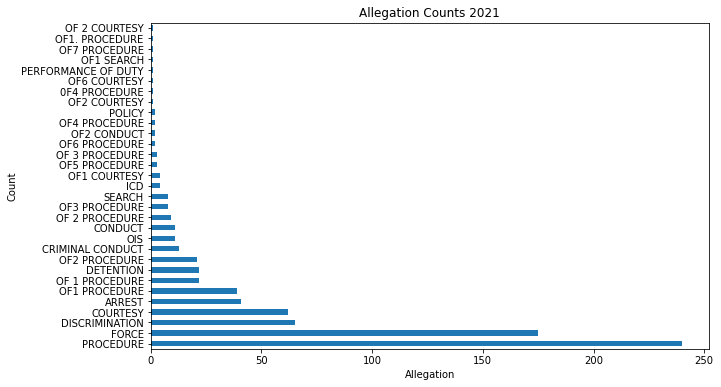

In [35]:
alleg_count_21 = allegations_21['allegation'].value_counts()

plt.figure(figsize=(10,6))
alleg_count_21.plot(kind='barh')

plt.title('Allegation Counts 2021')
plt.xlabel('Allegation')
plt.ylabel('Count')

plt.show()

In [26]:
cases_21 = pd.DataFrame(pd.read_sql('SELECT * FROM crb_cases_fy2021_datasd', cnx))
cases_21.head()

,id,case_number,team,date_assigned,date_completed,date_presented,days_number,days_30_or_less,days_60_or_less,90_days_or_less,120_days_or_less,changes,pd_division,complainant_race,complainant_gender,crb_viewed_bwc
0,21-01,2019-0671,6.0,2020-05-06,2020-07-11,2020-07-28,66.0,NO,NO,YES,NO,NO,MID-CITY,B,M,YES
1,21-02,2019-0617,6.0,2020-04-23,2020-07-11,2020-07-28,79.0,NO,NO,YES,NO,NO,NATIONAL CITY Special ops,,F,YES
2,21-03,2019-0547,7.0,2020-01-22,2020-02-26,2020-08-04,35.0,NO,YES,YES,YES,NO,NORTHEASTERN,H,F,YES
3,21-04,2019-0707,7.0,2020-02-12,2020-03-16,2020-08-04,33.0,NO,YES,YES,YES,NO,500 PARK AVENUE,B,M,YES
4,21-05,2019-0049,7.0,2019-12-09,2020-05-31,2020-08-04,174.0,NO,NO,NO,NO,YES,MID-CITY,W,M,YES


In [25]:
cases_22 = pd.DataFrame(pd.read_sql('SELECT * FROM crb_cases_fy2022_datasd', cnx))
cases_22.head()

,id,case_number,team,date_assigned,date_completed,date_presented,days_number,days_30_or_less,days_60_or_less,90_days_or_less,120_days_or_less,changes,pd_division,complainant_race,complainant_gender,crb_viewed_bwc
0,22-01,2019-0241,7.0,2019-09-05,2021-03-02,2021-07-13,544.0,NO,NO,NO,NO,YES,SOUTHEASTERN,B,M,YES
1,22-02,2020-0576,2.0,2021-05-14,2021-06-30,2021-07-13,47.0,NO,YES,YES,YES,NO,SOUTHEASTERN,B,M,YES
2,22-03,2020-0450,1.0,2021-05-04,2021-07-02,2021-07-13,59.0,NO,YES,YES,YES,YES,WESTERN,H,M,YES
3,22-04,2021-0015,2.0,2021-05-06,2021-07-06,2021-07-13,61.0,NO,NO,YES,YES,NO,NORTHERN,W,M,YES
4,22-05,2020-0356,3.0,2021-04-14,2021-07-08,2021-07-20,85.0,NO,NO,YES,YES,NO,CENTRAL,H,F,YES


In [30]:
len(cases_22)

103

In [31]:
len(cases_21)

124

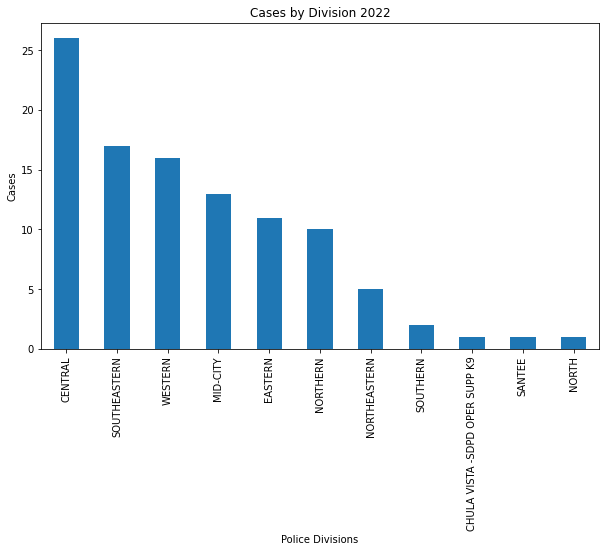

In [34]:
div_count_22 = cases_22['pd_division'].value_counts()

plt.figure(figsize=(10,6))
div_count_22.plot(kind='bar')

plt.title('Cases by Division 2022')
plt.xlabel('Police Divisions')
plt.ylabel('Cases')

plt.show()

In [33]:
ax = cases_22.plot.bar(x="pd_division", figsize=(9,7))
ax.set_title('Police Divisions')
ax.set_ylabel('Number of cases')
#plt.savefig('product_line_rev.png')
#create_slide('product_line_rev.png')

TypeError: no numeric data to plot